# Week 9 과제 1

**잎 사진을 통한 질병 분류**

*   데이터: 21개의 클래스로 구분된 약 20000장의 이미지
><img src="https://drive.google.com/uc?id=1YQkxnNy61Gyi3Gp6ylCKeS72BVruJXr_" width="700" height="500"> 
*   데이터 전처리
    *   전체 데이터를 train,validation,test로 분할해주세요
    *   저는 6:2:2로 분할했는데, 비율은 바꾸셔도 무방합니다.
   
    
*   학습 진행 방향
    *   Baseline 모델(pre-trained model 사용X) 구축
    *   Pre-trained 모델 사용
    *   Baseline과 ResNet50 모델의 성능을 비교해주세요 ~!

In [1]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')

# # 경로 설정 -  사용하지 않습니다 (구글 드라이브가 아닌 코랩 환경에 압축을 풀고 싶었기 때문)
# import os
# os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


In [2]:
!unzip -d /content/dataset -q /content/gdrive/MyDrive/Datasets/tobigs_week9_plant_leaf_data.zip

## 0. 데이터 분할

* 데이터 분할을 위한 디렉토리 생성

In [3]:
import os
import shutil
 
original_dataset_dir = '/content/dataset/tobigs_week9_plant_leaf'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = './splitted' # 기본 경로 생성 및 지정
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train') # train 폴더 만들기
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val') # val 폴더 만들기
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test') # test 폴더 만들기
os.mkdir(test_dir)

for cls in classes_list:     
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

* 데이터 분할과 클래스별 데이터 수 확인

In [4]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    # train : val : test = 0.6 : 0.2 : 0.2로 나눈다
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    # train 데이터를 잘라서 배열의 index획득
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        # train 폴더로 파일 복사
        shutil.copyfile(src, dst)
        
    # validation 데이터를 잘라서 배열의 index획득
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        # validation 폴더로 파일 복사
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    # test 데이터를 잘라서 배열의 index획득
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        # test 폴더로 파일 복사
        shutil.copyfile(src, dst)


Train size( Pepper,_bell___healthy ):  886
Validation size( Pepper,_bell___healthy ):  295
Test size( Pepper,_bell___healthy ):  295
Train size( Apple___Black_rot ):  372
Validation size( Apple___Black_rot ):  124
Test size( Apple___Black_rot ):  124
Train size( Corn___Common_rust ):  715
Validation size( Corn___Common_rust ):  238
Test size( Corn___Common_rust ):  238
Train size( Potato___Early_blight ):  600
Validation size( Potato___Early_blight ):  200
Test size( Potato___Early_blight ):  200
Train size( Cherry___Powdery_mildew ):  631
Validation size( Cherry___Powdery_mildew ):  210
Test size( Cherry___Powdery_mildew ):  210
Train size( Grape___Esca_(Black_Measles) ):  829
Validation size( Grape___Esca_(Black_Measles) ):  276
Test size( Grape___Esca_(Black_Measles) ):  276
Train size( Cherry___healthy ):  512
Validation size( Cherry___healthy ):  170
Test size( Cherry___healthy ):  170
Train size( Pepper,_bell___Bacterial_spot ):  598
Validation size( Pepper,_bell___Bacterial_spot

총 21개의 클래스가 있으며, 각각의 데이터의 개수를 출력해 보았다.

## 1. 베이스라인 모델을 구축해 주세요
* Pre-Trained Model을 사용하지 않고 직접 모델을 구축해 주세요 !


In [10]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 128
EPOCH = 30 

In [28]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]) # AlexNet 구조를 위해 256으로 업스케일링
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

In [29]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [30]:
# 이미지 체크
for x, y in train_loader:
  print(f"x shape: {x.shape} / y shape: {y.shape}")
  break

x shape: torch.Size([128, 3, 256, 256]) / y shape: torch.Size([128])


`BATCH_SIZE` 가 256이고, 3차원(RGB의 256 256 픽셀이다)인것을 확인했다.

* 베이스라인 모델 설계하기

지난 시간에 배웠던 `AlexNet`의 기본 구조를 사용했습니다.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 
        # 기본적인 AlexNet을 구현하여 사용.
        self.convLayers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.denseLayers = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 21), # 총 21개의 클래스를 가지고 있다.
        )

    def forward(self, x):  

        x = self.convLayers(x)
        x = torch.flatten(x, 1)
        x = self.denseLayers(x)


        return F.log_softmax(x, dim=1)

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

* 모델 학습을 위한 함수
* 모델 학습, 평가를 위한 가이드라인 코드입니다. 꼭 이 코드를 사용하지는 않으셔도 됩니다 !!

In [19]:
criterion = nn.CrossEntropyLoss()

In [6]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)  #Cross Entropy Loss 사용했습니다
        loss.backward()
        optimizer.step()

* 모델 평가를 위한 함수

In [7]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data)
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

* 모델 학습을 실행하기

In [31]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer,num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)
        
        if best_acc < val_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

    model.load_state_dict(best_model_wts)  
    return model
 

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)  	
# 구글 드라이브에 모델이 저장되도록 경로를 수정했습니다.
torch.save(base,'/content/gdrive/MyDrive/trained_model/tobigsAssign/baseline.pt')

-------------- epoch 1 ----------------
train Loss: 2.7579, Accuracy: 16.89%
val Loss: 2.7343, Accuracy: 16.74%
Completed in 1m 2s
-------------- epoch 2 ----------------
train Loss: 2.5370, Accuracy: 19.21%
val Loss: 2.5191, Accuracy: 19.14%
Completed in 1m 3s
-------------- epoch 3 ----------------
train Loss: 2.1807, Accuracy: 29.49%
val Loss: 2.1759, Accuracy: 28.38%
Completed in 1m 3s
-------------- epoch 4 ----------------
train Loss: 1.8055, Accuracy: 42.27%
val Loss: 1.8263, Accuracy: 42.06%
Completed in 1m 3s
-------------- epoch 5 ----------------
train Loss: 1.0841, Accuracy: 63.14%
val Loss: 1.1282, Accuracy: 61.57%
Completed in 1m 3s
-------------- epoch 6 ----------------
train Loss: 0.8904, Accuracy: 69.43%
val Loss: 0.9347, Accuracy: 67.65%
Completed in 1m 3s
-------------- epoch 7 ----------------
train Loss: 0.7567, Accuracy: 73.18%
val Loss: 0.7934, Accuracy: 71.98%
Completed in 1m 3s
-------------- epoch 8 ----------------
train Loss: 0.5866, Accuracy: 79.86%
val Lo

기본적인 AlexNet을 활용해 보니 train Accuracy가 99.8%까지 올라가는 것을 확인할 수 있었지만,

validation Accuracy 가 90% 정도에서 정체되어 있는것을 확인할 수 있었다.

모델 깊이와 같은 문제 때문으로 생각이 든다.


## 2. Transfer Learning 모델 학습

* Transfer Learning을 위한 준비
* Transfer Learning이 익숙하지 않으신 분들은 PyTorch에서 제공하는 https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html 을 참고하세요 :)

Data augmentation을 위해 사용한 방법과 근거

- `Randomcrop` : 잎이 중앙에 위치해 있지만, 비율을 작게 하면 이미지의 특징을 유지하면서도 자르는 것이 가능할 것으로 보인다.
- `RandomRotation` : 이미지를 살짝씩 기울여도 상관없을 것이라 생각된다.
- `RandomHorizontalFlip` : 잎은 좌우의 구분이 없기 때문에 큰 문제가 되지 않을 것으로 생각했다.
- `RandomVerticalFlip` : 위와 마찬가지로 상하의 구분이 없을 것이라고 생각했다.
- `Colorjitter` : 이미지의 밝기를 변화시켜도 잎의 종류를 구분하는 데 큰 문제가 되지 않을 것으로 생각했다.

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256,256]), # 살짝 확대후 나중에 자르기. Resnet 의 Input은 224입니다.
        transforms.RandomCrop(224),
        transforms.RandomRotation(30), # 30도씩 회전
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
    
    'val': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.CenterCrop(224),
        # validation에는 데이터 증감을 가하지 않습니다
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ])
}

In [10]:
# augmentation 된 데이터 불러오기
train_dataset_aug = ImageFolder(root='./splitted/train', transform=data_transforms['train']) 
val_dataset_aug = ImageFolder(root='./splitted/val', transform=data_transforms['val'])

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset_aug,batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

train image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

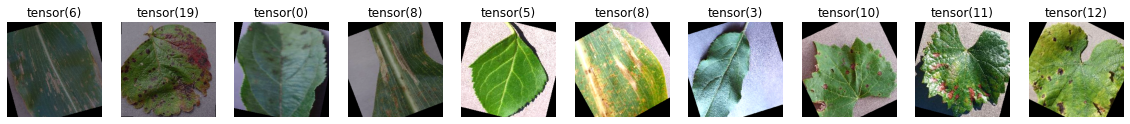

val image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


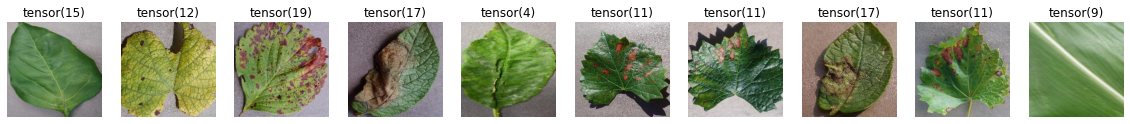

In [15]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


print('train image')
for image, label in train_loader:
  plt.figure(figsize=(20, 2))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    img = std * image[i].numpy().transpose((1, 2, 0)) + mean
    plt.imshow(img)
    plt.title(label[i])
  break
plt.show()

print('val image')
for image, label in val_loader:
  plt.figure(figsize=(20, 2))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    img = std * image[i].numpy().transpose((1, 2, 0)) + mean
    plt.imshow(img)
    plt.title(label[i])
  break
plt.show()

정상적으로 Data augmentation이 된 것을 확인할 수 있었으며, 인식하는 데 큰 차이가 없이 인식되는 것을 확인할 수 있었다.

### Pre-Trained Model 불러오기
> - 저는 ResNet50을 사용했는데, 코랩 기준으로 다른 ResNet계열이나 DenseNet 정도까지는 큰 무리 없이 훈련할 수 있습니다. Unfreeze layer 수가 적으면 다른 모델도 사용할 수 있을 것입니다.
- 한 가지 모델을 선택해서 Transfer Learning을 해 주세요 !!


`ResNet`을 그대로 import 해서 사용했다.

`ResNet`을 직접 구현해서 사용하지 않고 Transfer Learning을 통해 학습시켜 보았다.

In [17]:
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  # resnet 모델 데이터 불러오기
num_ftrs = resnet.fc.in_features  # fc 층에 들어가는 feature의 수 == 2048
resnet.fc = nn.Linear(num_ftrs, 21) # 레이어 대체 
resnet = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

from torch.optim import lr_scheduler  #scheduler는 사용하지 않으셔도 됩니다 (선택사항)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  #7에폭마다 learning rate를 조절하는 역할을 합니다

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


* Pre-Trained Model의 일부 Layer Freeze하기 (resnet 기준입니다 !!)

In [14]:
ct = 0 
for child in resnet.children():   # 상위 5개 레이어 freeze
    ct+= 1  
    if ct < 6: 
        # print(child)
        for param in child.parameters():
            param.requires_grad = False

* Fine Tuning을 진행해주세요 ~!

In [20]:
import time
import copy

# train, evaluate 함수는 기존과 완전히 같으므로 계속 사용하겠습니다.
def train_baseline(model ,train_loader, val_loader, optimizer,num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)
        
        if best_acc < val_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
            print("model saved")
            torch.save(model,'/content/gdrive/MyDrive/trained_model/tobigsAssign/finetune.pt')
        exp_lr_scheduler.step() # 스케줄러에게 한 에폭이 끝났다고 알려주는 코드 추가
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 


    model.load_state_dict(best_model_wts)  
    return model
 

base = train_baseline(resnet, train_loader, val_loader, optimizer_ft, EPOCH)  	
torch.save(base,'/content/gdrive/MyDrive/trained_model/tobigsAssign/finetune.pt')

model saved
-------------- epoch 1 ----------------
train Loss: 0.2130, Accuracy: 93.11%
val Loss: 0.1786, Accuracy: 94.33%
Completed in 2m 23s
model saved
-------------- epoch 2 ----------------
train Loss: 0.1138, Accuracy: 96.37%
val Loss: 0.1078, Accuracy: 96.45%
Completed in 2m 29s
model saved
-------------- epoch 3 ----------------
train Loss: 0.1397, Accuracy: 95.94%
val Loss: 0.0743, Accuracy: 97.86%
Completed in 2m 29s
model saved
-------------- epoch 4 ----------------
train Loss: 0.0562, Accuracy: 98.21%
val Loss: 0.0537, Accuracy: 98.41%
Completed in 2m 29s
-------------- epoch 5 ----------------
train Loss: 0.0621, Accuracy: 98.15%
val Loss: 0.0527, Accuracy: 98.17%
Completed in 2m 29s
-------------- epoch 6 ----------------
train Loss: 0.0915, Accuracy: 97.05%
val Loss: 0.1158, Accuracy: 96.97%
Completed in 2m 29s
-------------- epoch 7 ----------------
train Loss: 0.0450, Accuracy: 98.49%
val Loss: 0.0468, Accuracy: 98.30%
Completed in 2m 29s
model saved
-------------- e

validation score 가 **99.6% 이상으로 충분히 높게 나온 것을 확인할 수 있다.**

또한 **처음부터 트레이닝을 실행하는 것과 달리 1에폭 부터 90%대의 정확도가** 나오는 것을 확인할 수 있다. 이는 이미 사전 학습된 가중치이기 때문에 다른 이미지 문제에도 적용될 수 있는 것이다.

## 모델 평가

* 모델 평가를 위해서는 평가 데이터 또한 전처리를 해주어야 합니다.
* validation 데이터와 동일하게 전처리를 해 주세요 ~!!

두 모델 다 기존에 사용했던 전처리를 그대로 적용하여 사용했다.

* 베이스라인 모델 평가를 위한 전처리하기

In [13]:
transform_base = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_base = ImageFolder(root='./splitted/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

* Transfer Learning모델 평가를 위한 전처리하기

In [14]:
transform_resNet = transforms.Compose([
        transforms.Resize([256,256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ])
    
test_resNet = ImageFolder(root='./splitted/test', transform=transform_resNet) 
test_loader_resNet = torch.utils.data.DataLoader(test_resNet,batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### 성능 평가하기
* 저는 여기서 accuracy만을 평가했지만, 분류 모델이기에 다양한 방법의 평가가 가능합니다.
* Confusion Matrix를 이용한 비교도 가능하고, 한 작물에 해당하는 클래스가 여러개인 다중 분류에서 F1-score를 계산하는것도 의미가 있을 것입니다. 
* 다양한 시도를 하시는 분께 가산점 드리겠습니다 :):)

* 베이스라인 모델 성능 평가하기

In [18]:
baseline=torch.load('/content/gdrive/MyDrive/trained_model/tobigsAssign/baseline.pt') 
baseline.eval()
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('test acc:  ', test_accuracy)

test acc:   92.21932114882506


* Transfer Learning 모델 성능 평가하기

In [19]:
resnet50=torch.load('/content/gdrive/MyDrive/trained_model/tobigsAssign/finetune.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('test acc:  ', test_accuracy)

test acc:   99.47780678851174


* 두 모델의 성능을 비교 평가하는 설명을 작성해주세요 ~!!

Accuracy 만을 확인해 보았을 때, 일반 BaseLine을 활용한 모델은 92.2%의 정확도가 나온 반면, Transfer Learning을 활용한 경우의 정확도가 **99.47%로 상당히 높게 나타났다.**

또한 학습 기록을 확인해 볼 때 **정확도가 빠르게 높아지는 모습을 확인할 수 있었다**. 9에폭만에 99% 이상의 정확도를 달성한 것으로 볼 때 적은 컴퓨팅 자원과 더 빠른 시간에 높은 정확도를 얻을 수 있을 것으로 보인다.


# f1 score 및 confusion matrix

In [39]:
def predict(model, test_loader):
    model.eval()
    result = None
    targets = None
    with torch.no_grad(): 
        for data, target in test_loader:  
            data = data.to(DEVICE)
            if result is None:
              result = model(data).cpu().numpy()
              targets = target.cpu().numpy()
            else:
              result = np.concatenate((result, model(data).cpu().numpy()))
              targets = np.concatenate((targets, target))
    return result, targets

In [66]:
# 패키지 임포트
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

baseline 의 confusion matrix, f1-score

In [73]:
y_pred_base, y_true_base = predict(baseline, test_loader_base)

In [65]:
f1_score(y_true_base, y_pred_base.argmax(axis=1), average=None)

array([0.7699115 , 0.92622951, 0.84955752, 0.92899408, 0.93764434,
       0.94647887, 0.7628866 , 0.99790356, 0.87281796, 0.99570815,
       0.90376569, 0.94382022, 0.9478673 , 0.9132948 , 0.92857143,
       0.93814433, 0.95431472, 0.85853659, 0.62686567, 0.93793103,
       0.94680851])

In [68]:
confusion_base = confusion_matrix(y_true_base, y_pred_base.argmax(axis=1))

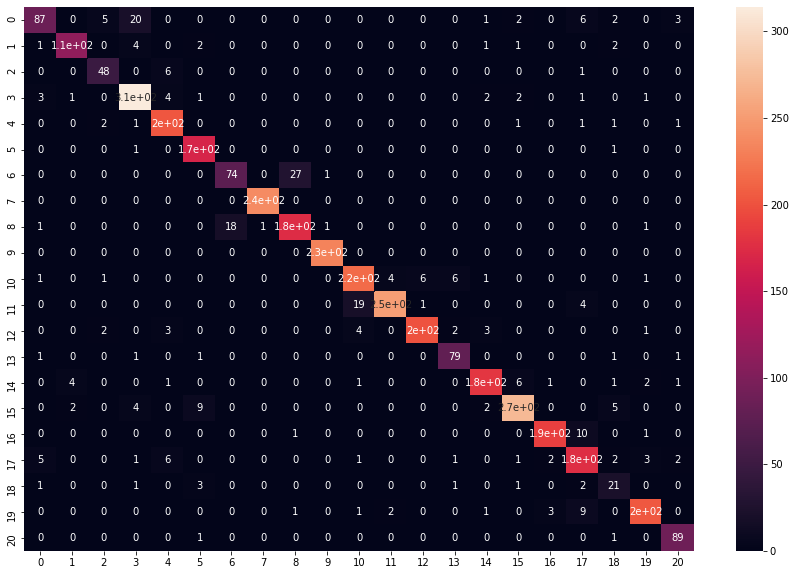

In [72]:
plt.figure(figsize = (15, 10))
sn.heatmap(confusion_base, annot=True)
plt.show()

resnet 의 confusion matrix, f1-score

In [74]:
y_pred_res, y_true_res = predict(resnet50, test_loader_resNet)
confusion_res = confusion_matrix(y_true_res, y_pred_res.argmax(axis=1))
f1_score(y_true_res, y_pred_res.argmax(axis=1), average=None)

array([0.99601594, 0.99595142, 1.        , 1.        , 0.9976247 ,
       1.        , 0.92682927, 0.99789474, 0.96202532, 1.        ,
       0.99578059, 0.99818512, 1.        , 1.        , 0.99749373,
       0.99830221, 1.        , 1.        , 1.        , 0.99773243,
       1.        ])

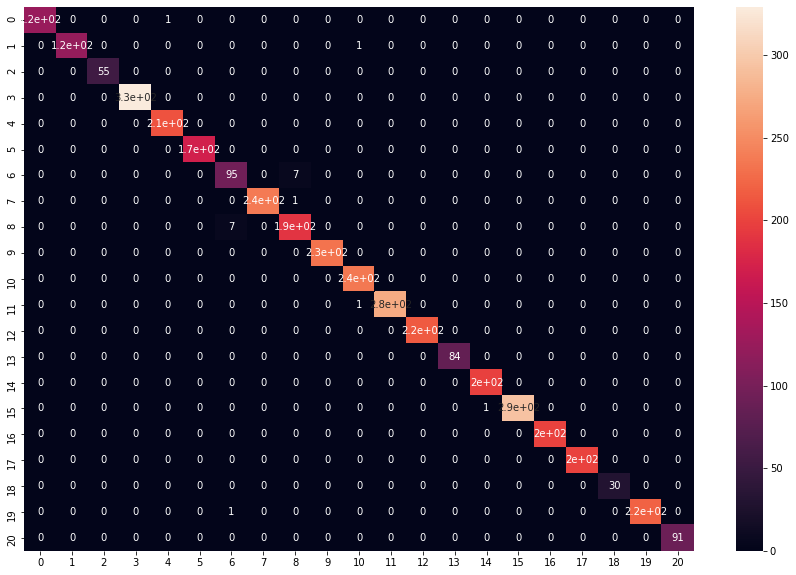

In [75]:
plt.figure(figsize = (15, 10))
sn.heatmap(confusion_res, annot=True)
plt.show()

confusion matrix를 확인해 보면 BaseLine에 비해서 틀린 경우가 거의 없는 것을 확인할 수 있다.

f1-score 를 확인해 보면 '1.' (모두 정답)인 클래스도 몇개 보인다. 즉 예측력이 증가하는 것을 확인할 수 있었다.
